In [1]:
#Step 1 : Data Collection
#Step 2 : Feature Extraction | Faces in this case
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
img = cv2.imread(r"Dataset\Ronaldo\10001.jpg")
img.shape

(249, 203, 3)

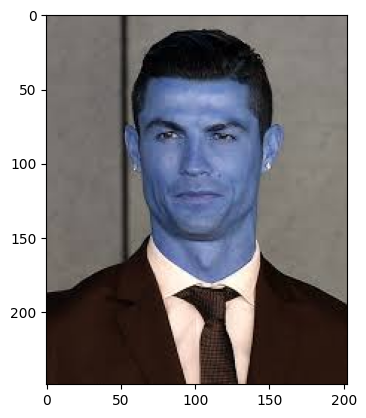

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # cvt color : convert color | BGR to GRAY
gray.shape

(249, 203)

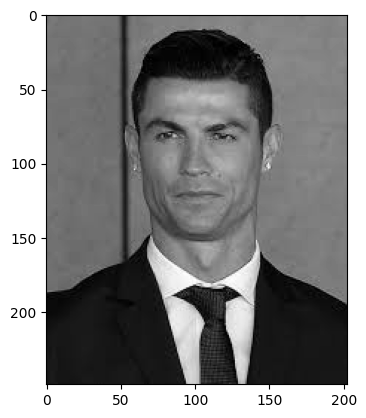

In [5]:
plt.imshow(gray, cmap="gray")

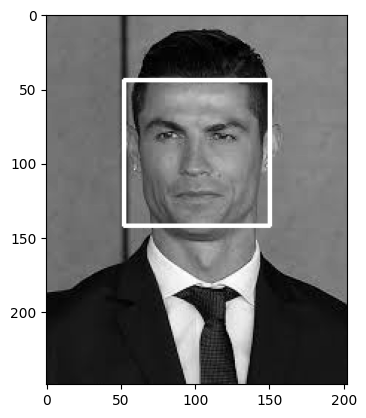

In [6]:
FaceCascade = cv2.CascadeClassifier("haarcascades\haarcascades\haarcascade_frontalface_default.xml")
faces = FaceCascade.detectMultiScale(gray,1.1,4)

for (x,y,w,h) in faces:
    face_img = cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)
    #Features ko extract krna hai aur ek naye variable mein save krna hai
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = face_img[y:y+h,x:x+w]

plt.figure()
plt.imshow(face_img, cmap="gray")
plt.show()

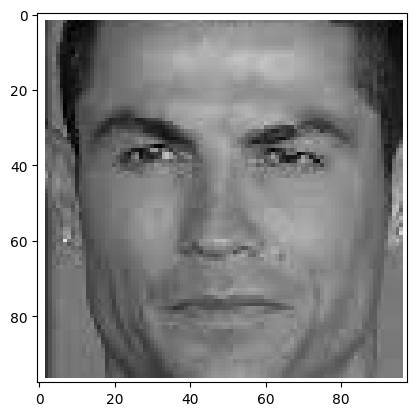

In [7]:
plt.imshow(roi_gray, cmap="gray")

In [8]:
path_to_data = "Dataset"
path_to_cr_data = "Dataset/cropped/"

In [9]:
img_dirs = ["Dataset/HP","Dataset/MSD","Dataset/ViratKohli","Dataset/Ronaldo"] #giving the path of all the three directories jahan par humein kaam krna hai

In [10]:
import shutil #Checks and or removes data
import os
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [11]:
def Get_cropped_face(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = FaceCascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        
        return roi_color

In [12]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split("/")[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = Get_cropped_face(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

HP
Generating cropped images in folder:  Dataset/cropped/HP
MSD
Generating cropped images in folder:  Dataset/cropped/MSD
ViratKohli
Generating cropped images in folder:  Dataset/cropped/ViratKohli
Ronaldo
Generating cropped images in folder:  Dataset/cropped/Ronaldo


In [13]:
class_dict={}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count+=1
print(class_dict)

{'HP': 0, 'MSD': 1, 'ViratKohli': 2, 'Ronaldo': 3}


In [14]:
def w2d(img):
    imArray = img
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    
    imArray =  np.float32(imArray)   
    imArray /= 255
  

    return imArray

In [15]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [16]:
len(X[0])

4096

In [17]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(115, 4096)

In [18]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [19]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [20]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [22]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logisti

,model,best_score,best_params
0,svm,0.605229,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.523529,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.535948,{'logisticregression__C': 1}


In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your dataset
dataset_dir = 'dataset\cropped'

# Data augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of the data will be used for validation
)

# Create generators
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
   
    class_mode='binary',  # or 'categorical' for multi-class
    subset='training'  # set as training data
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    
    class_mode='binary',  # or 'categorical' for multi-class
    subset='validation'  # set as validation data
)


Found 95 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [24]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # or 'softmax' for multi-class
])


C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.compile(
    loss='binary_crossentropy',  # or 'categorical_crossentropy' for multi-class
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)


In [26]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/30


C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 800ms/step - accuracy: 0.1918 - loss: 0.4620 - val_accuracy: 0.2000 - val_loss: -0.7186
Epoch 2/30
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.3125 - loss: -0.7333

c:\Program Files\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.3125 - loss: -0.7333 - val_accuracy: 0.2000 - val_loss: -1.6865
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - accuracy: 0.2315 - loss: -2.4393 - val_accuracy: 0.2000 - val_loss: -4.4454
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.1875 - loss: -3.7668 - val_accuracy: 0.2000 - val_loss: -6.5157
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 569ms/step - accuracy: 0.2105 - loss: -8.9050 - val_accuracy: 0.2000 - val_loss: -12.8170
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.2188 - loss: -11.6314 - val_accuracy: 0.2000 - val_loss: -18.2098
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - accuracy: 0.2188 - loss: -19.4840 - val_accuracy: 0.2000 - val_loss: -30.9731
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.1935 - loss: -36.1800 - val_accuracy: 0.2000 - val_loss: -41.6606
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 479ms/step - accuracy: 0.1579 - loss: -46.5625 - val_accuracy: 0.2000

In [27]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.2000 - loss: -4093.1516
Test accuracy: 0.20000000298023224
